In [1]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬\n', confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [2]:
from sklearn.metrics import precision_recall_curve

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold 값으로 Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(6,4))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], ls='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    # threshold 값 X축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # x축, y축 label과 legend 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

### 4.10 캐글 신용카드 사기 검출
    - Class 레이블: 0(정상적인 신용카드 트랜잭션 데이터), 1(신용카드 사기 트랜잭션)
    - 약 0.172%만이 사기 트랜잭션(1)인 매우 불균형한 분포

> ***언더 샘플링과 오버 샘플링***
    
    레이블이 극도로 불균형한 분포를 가진 데이터 세트를 학습시킬 때, 일방적으로 정상 레이블로 치우친 학습을 수행해 제대로 된 이상 데이터 검출이 어려워지는 문제 발생 (이상 레이블을 가진 데이터 건수는 매우 적어 제대로 다양한 유형을 학습하지 못하기 때문)
    
    * 적절한 학습 데이터를 확보하는 방안
    1) 오버 샘플링 (Oversampling)
    : 적은 레이블을 가진 데이터 세트를 많은 레이블을 가진 데이터 세트 수준으로 증식
    <-> 너무 많은 정상 레이블을 감소시키는 경우 제대로 된 학습을 수행할 수 없게 됨
    
    2) 언더 샘플링 (Undersampling)
    : 많은 레이블을 가진 데이터 세트를 적은 레이블을 가진 데이터 세트 수준으로 감소. 이때 단순히 동일한 데이터를 증식하는 방법은 과적합을 유발하므로, 원본 데이터의 피처 값들을 아주 약간만 변경하여 증식
    
    ex. SMOTE: 적은 데이터 세트에 있는 개별 데이터들의 K 최근접 이웃을 찾아 이 데이터와 K개 이웃들의 차이를 일정값으로 만들어 약간 차이가 나는 새로운 데이터들을 생성
    

> ***데이터 일차 가공 및 모델 학습/예측/평가***

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
card_df = pd.read_csv('./creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [5]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

- V로 시작하는 피처들의 의미는 알 수 없다
- Time 피처는 데이터 생성 관련한 속성으로 의미가 없다 > drop
- Amount 피처: 신용카드 트랜잭션 금액
- Class 레이블: 0(정상), 1(사기)
- 총 284807개의 레코드 중 결측치는 없다
- Class 레이블(int형) 제외 모두 float형

In [6]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

In [7]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수
def get_train_test_df(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    
    # DataFrame의 맨 마지막 칼럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:,-1]

    # train_test_split()으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    # Stratified 기반 분할: 원본 데이터의 불균형한 레이블 비율을 맞춰서 분할
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, 
                                                        test_size=0.3, random_state=0, stratify=y_target)
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_df(card_df)

In [8]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('\n테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
Class
0    99.827451
1     0.172549
Name: count, dtype: float64

테스트 데이터 레이블 값 비율
Class
0    99.826785
1     0.173215
Name: count, dtype: float64


- 원본 데이터와 유사하게 레이블 값이 1인 데이터 건수가 약 0.172%

In [9]:
## 로지스틱 회귀 기반의 모델 생성
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=100)
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
 [[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014, F1: 0.7149, AUC: 0.9567


In [10]:
# 반복적으로 모델을 변경해 학습/예측/평가할 것이므로 이를 위한 get_model_train_eval()
# 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력 받아 학습/예측/평가 수행
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:,1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [11]:
## LightGBM 기반의 모델 생성
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

오차 행렬
 [[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568, F1: 0.8453, AUC: 0.9790


> ***데이터 분포도 변환 후 모델 학습/예측/평가***

    대부분의 선형 모델 (ex. 로지스틱 회귀) 은 중요 피처들의 값이 정규 분포 형태를 유지하는 것을 선호함 !
    -> Amount 피처는 신용카드 사용 금액으로 정상/사기 트랜잭션을 결정하는 매우 중요한 피처일 가능성이 높다

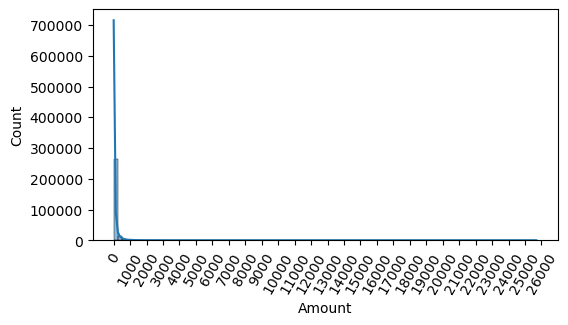

In [12]:
# Amount 피처의 분포도
import seaborn as sns

plt.figure(figsize=(6,3))
plt.xticks(range(0,30000,1000), rotation=60)
sns.histplot(card_df.Amount, bins=100, kde=True)
plt.show()

- 1000불 이하인 데이터가 대부분이며, 26000불까지 드물지만 많은 금액을 사용한 경우가 발생하며 꼬리가 긴 형태의 분포

In [13]:
# Amount를 표준 정규분포 형태로 변환 후 로지스틱 회귀의 예측 성능 측정
from sklearn.preprocessing import StandardScaler

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1)) # 2차원 배열로 변환
    # 변환된 Amount를 Amount_Scaled로 피처명 변경 후 DataFrame 맨 앞 칼럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    
    return df_copy

In [14]:
# 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_df(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('\n### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
 [[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081, F1: 0.7143, AUC: 0.9702

### LightGBM 예측 성능 ###
오차 행렬
 [[85290     5]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500, F1: 0.8409, AUC: 0.9779


- 큰 성능 변화는 없음. 오히려 저하된 성능 평가 지표 존재

In [15]:
## 데이터 분포도가 심하게 왜곡되어 있을 경우 적용하는 중요 기법 중 하나인 로그 변환 이용
# 원래 값을 log 값으로 변환해 원래 큰 값을 상대적으로 작은 값으로 변환하여 데이터 분포도의 왜곡을 상당 수준 개선하는 방식

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 넘파이의 log1p()를 이용해 Amount를 로그 변환
    amount_n = np.log1p(df_copy.Amount)
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [16]:
# 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_df(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('\n### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
 [[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014, F1: 0.7149, AUC: 0.9727

### LightGBM 예측 성능 ###
오차 행렬
 [[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635, F1: 0.8496, AUC: 0.9796


- 레이블이 극도로 불균일한 데이터 세트에서 로지스틱 회귀는 데이터 변환 시 약간은 불안정한 성능 결과를 나타냄

> ***이상치 데이터 제거 후 모델 학습/예측/평가***
    
    이상치(Outlier): 전체 데이터 패턴에서 벗어난 이상 값을 가진 데이터. ML 모델 성능에 영향을 미칠 수 있으므로 이를 제거할 필요 !
    
    [IQR 방식] (IQR = Q3-Q1) > Q3 + 1.5 * IQR 이상 or Q1 - 1.5 * IQR 이하를 이상치 데이터로 간주
    
    * 피처가 매우 많을 경우,
    모든 피처들의 이상치를 검출하는 것은 시간이 많이 소모되며 레이블과 큰 관련 없는 피처는 성능 향상에도 기여하지 않으므로
    '레이블과 가장 상관성이 높은 피처들을 위주로 이상치를 검출'하는 것이 좋다 !

<Axes: >

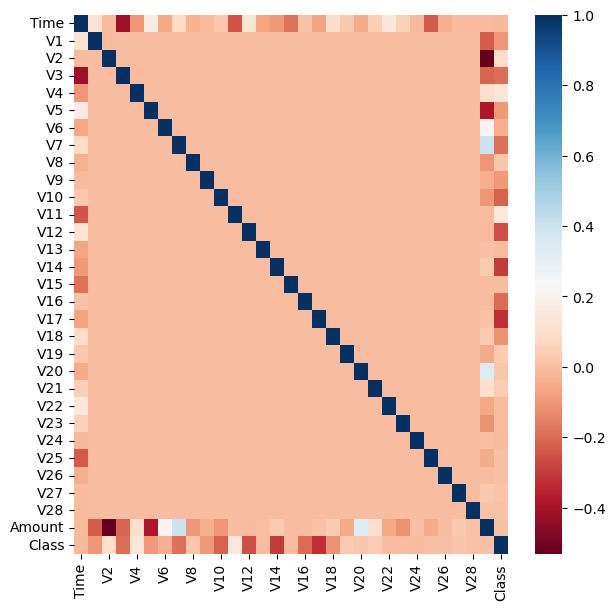

In [17]:
# 각 피처별 상관도를 확인하기 위한 heatmap 시각화
import seaborn as sns

plt.figure(figsize=(7,7))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

- Class 레이블과 가장 상관도가 높은 피처는 V17, V14

In [18]:
## V14에 대해서만 이상치 제거
import numpy as np

def get_outlier(df=None, column=None, weight=1.5): # 이상치를 검출하는 함수
    # fraud에 해당하는 column 데이터만 추출. Q1과 Q3 지점을 np.percentile로 구함
    fraud = df[df.Class==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    # IQR을 구하고, 1.5를 곱해 최댓값과 최솟값 지점 구함
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    # 최댓값보다 크거나, 최솟값보다 작은 값들을 이상치 데이터로 설정하고 DataFrame index로 반환
    outlier_index = fraud[(fraud > highest_val) | (fraud < lowest_val)].index
    return outlier_index

In [19]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Index([8296, 8615, 9035, 9252], dtype='int64')


- 총 4개의 데이터인 8296, 8615, 9035, 9252번 Index가 이상치로 추출되었음

In [20]:
# get_preprocessed_df()를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 넘파이의 log1p()를 이용해 Amount를 로그 변환
    amount_n = np.log1p(df_copy.Amount)
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

In [21]:
# 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_df(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('\n### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
 [[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712, F1: 0.7597, AUC: 0.9743

### LightGBM 예측 성능 ###
오차 행렬
 [[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288, F1: 0.8897, AUC: 0.9780


- 로지스틱 회귀) 재현율 0.6014 > 0.6712
- LightGBM) 재현율 0.7635 > 0.8288
- 모두 예측 성능이 크게 향상되었음

> ***SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가***

    반드시 학습 데이터 세트만! 오버 샘플링 해야함
    -> 검증/테스트 데이터 세트를 오버 샘플링할 경우 결국은 원본 데이터 세트가 아닌 데이터 세트에서 검증 또는 테스트를 진행하게 되어 올바른 검증/테스트가 될 수 없음

In [22]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트:', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트:', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트: (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트: (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 Class
0    199020
1    199020
Name: count, dtype: int64


In [23]:
# 오버 샘플링으로 생성된 학습 데이터 세트를 기반으로 로지스틱 회귀 모델 학습/예측/평가
lr_clf = LogisticRegression(max_iter=1000)
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, X_train_over, X_test, y_train_over, y_test)

오차 행렬
 [[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247, F1: 0.1023, AUC: 0.9737


- 재현율은 92.47%로 크게 증가하지만, 반대로 정밀도는 5.42%로 급격하게 저하됨 > 적용 불가
- 오버 샘플링으로 인해 실제 원본 데이터의 유형보다 너무나 많은 Class=1 데이터를 학습하면서 정밀도가 급격히 떨어진 것 !

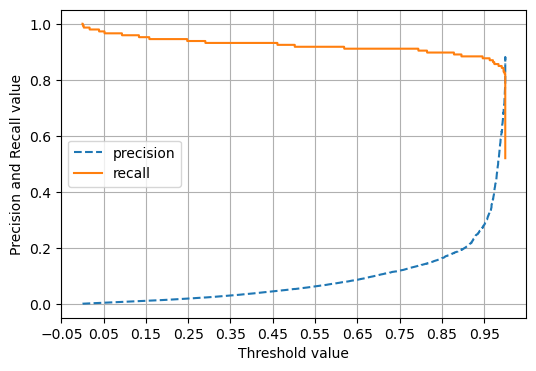

In [24]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

- 임계값이 0.99 이하에서는 재현율이 매우 좋고 정밀도가 극단적으로 낮다가, 0.99 이상에서는 반대로 재현율이 대폭 떨어지고 정밀도가 높아짐
- 임계값을 조정하더라도 임곗값의 민감도가 너무 심해 올바른 정밀도와 재현율을 얻기 어려워 보임
- 로지스틱 회귀 모델) SMOTE 적용 후 올바른 예측 모델 생성되지 못했음

In [25]:
# 오버 샘플링된 학습 데이터 세트를 기반으로 LightGBM 학습/예측/평가
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train_over, X_test, y_train_over, y_test)

오차 행렬
 [[85283    12]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9118, 재현율: 0.8493, F1: 0.8794, AUC: 0.9814


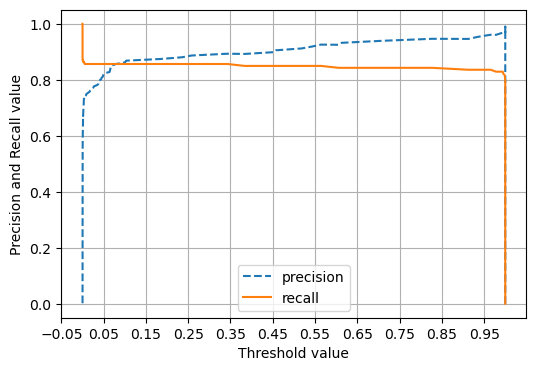

In [26]:
precision_recall_curve_plot(y_test, lgbm_clf.predict_proba(X_test)[:,1])

- 재현율이 이상치만 제거한 경우인 82.88%에서 84.93%로 향상
- 정밀도는 이전의 96.03%에서 91.18%로 저하
- SMOTE를 적용하면 재현율은 높아지나 정밀도는 낮아지는 것이 일반적임
- 다만, 정밀도 지표보다는 재현율 지표를 높이는 것이 머신러닝 모델의 주요한 목표인 경우 SMOTE를 적용하면 좋다 !

### 4.11 스태킹 앙상블


In [27]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size=0.2, random_state=0)

In [28]:
# 개별 ML 모델 생성
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
lr_final = LogisticRegression()

In [29]:
# 개별 모델들 학습
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [30]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 세트를 생성하고 개별 모델의 정확도 측정
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9123
에이다부스트 정확도: 0.9561


In [31]:
# 개별 알고리즘으로부터의 예측값을 칼럼 레벨로 옆으로 붙여 피처값으로 만들어,
# 최종 메타 모델인 로지스틱 회귀에서 학습 데이터로 다시 사용.
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환.
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [32]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타 모델의 예측 정확도: 0.9737


> **과적합 개선을 위한 CV 세트 기반의 스태킹**

**step 1**

    각 모델별로 원본 학습/테스트 데이터를 예측한 결과 값을 기반으로 
    메타 모델을 위한 학습용/테스트용 데이터 생성

**step 2**

    스텝 1에서 개별 모델들이 생성한 학습용/테스트용 데이터를 모두 스태킹 형태로 합쳐서 
    메타 모델이 학습할 최종 학습용/테스트용 데이터 세트를 생성.
    
    메타 모델은 최종적으로 생성된 학습 데이터 세트와 원본 학습 데이터의 레이블 데이터를 기반으로 
    학습한 뒤,
    최종적으로 생성된 테스트 데이터 세트를 예측하고, 원본 테스트 데이터의 레이블 데이터를 기반으로 평가

In [33]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    # 지정된 n_folds값으로 KFold 생성
    kf = KFold(n_splits=n_folds, shuffle=False)
    
    # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__, ' model 시작')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
        print('\t 폴드 세트: ', folder_counter, ' 시작')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        
        # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
        model.fit(X_tr, y_tr)
        # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
        train_fold_pred[valid_index,:] = model.predict(X_te).reshape(-1,1)
        # 입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장
        test_pred[:, folder_counter] = model.predict(X_test_n)
        
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred, test_pred_mean

In [34]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test, 7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier  model 시작
	 폴드 세트:  0  시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
	 폴드 세트:  5  시작
	 폴드 세트:  6  시작
RandomForestClassifier  model 시작
	 폴드 세트:  0  시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
	 폴드 세트:  5  시작
	 폴드 세트:  6  시작
DecisionTreeClassifier  model 시작
	 폴드 세트:  0  시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
	 폴드 세트:  5  시작
	 폴드 세트:  6  시작
AdaBoostClassifier  model 시작
	 폴드 세트:  0  시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
	 폴드 세트:  5  시작
	 폴드 세트:  6  시작


In [35]:
# 각 모델별 학습 데이터와 테스트 데이터를 합침
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:', X_train.shape,
     '원본 테스트 피처 데이터 Shape:', X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
     '스태킹 테스트 피처 데이터 Shape:', Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 데이터 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


In [36]:
# 최종 메타 모델인 로지스틱 회귀를 Stack_final_X_train, y_train으로 학습 후,
# Stack_final_X_test를 예측하고, 그 결고를 y_test와 비교해 정확도 측정
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9737


- 일반적으로 스태킹을 이루는 모델은 최적으로 파라미터를 튜닝한 상태에서 스태킹 모델을 만든다 !
- 개별 알고리즘 모델의 파라미터를 최적으로 튜닝한 상태를 말함